In [1]:
import os
import charts_function_list

In [2]:
_,datafolder,outputs=charts_function_list.folder_setup()

In [3]:
#Since the get_title_by_id function takes a while to complete, save as a new .csv for faster access later
os.chdir(datafolder)
sequels_with_ratings = pd.read_csv('sequels_with_rating.csv',index_col=[0,1])
sequels_with_ratings.dropna(inplace=True)
sequels_with_ratings = sequels_with_ratings[sequels_with_ratings.index.get_level_values(0)!='Star Trek'] #have 17, so need to drop one

In [25]:
sequels_with_ratings['rating'].std(level=0).sort_values().index

Index(['Step Up', 'Underworld', 'Resident Evil', 'Mission Impossible',
       'Fast and Furious', 'Final Destination', 'Child's Play', 'Saw',
       'Friday the 13th', 'Nightmare on Elm Street', 'Rocky', 'Scary Movie',
       'Die Hard', 'Police Academy', 'Halloween', 'House Party'],
      dtype='object', name='Category')

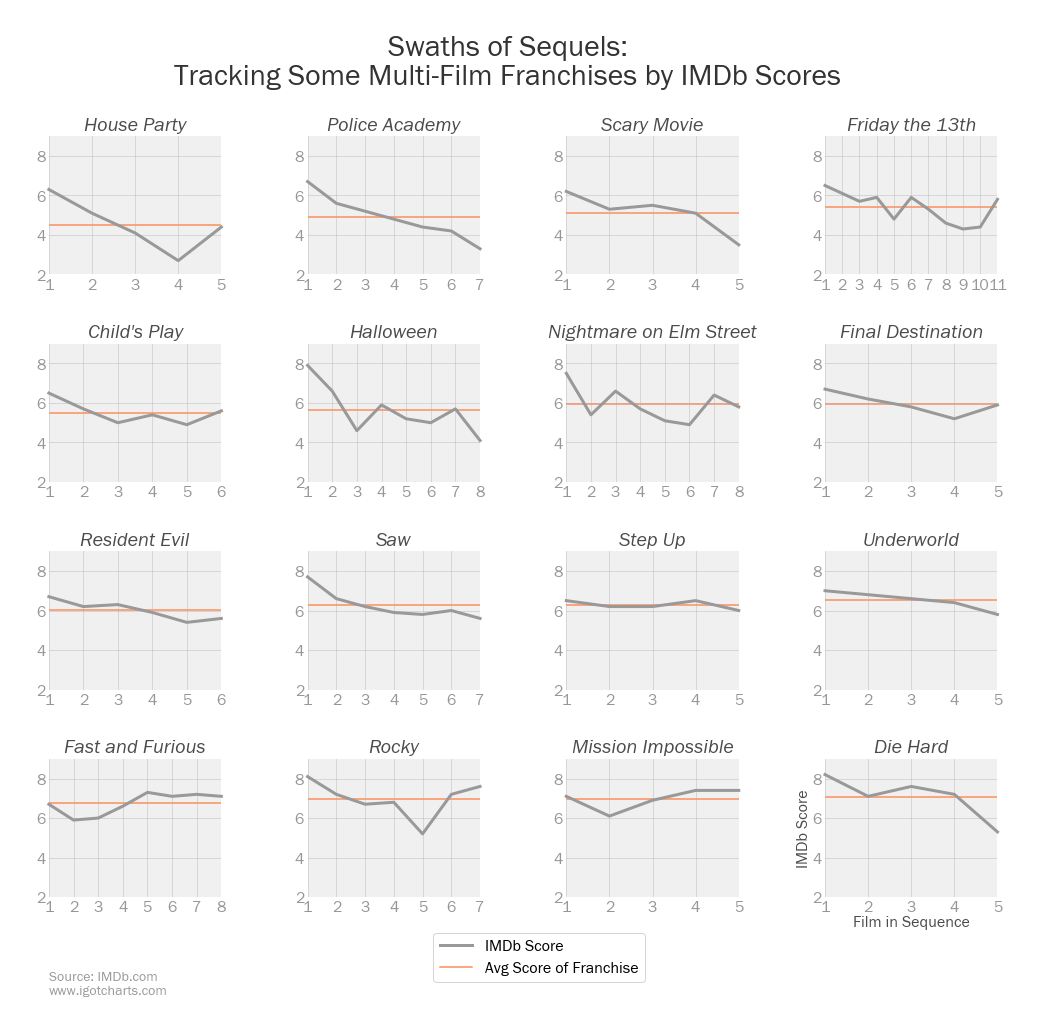

In [28]:

#sequel_titles = np.array(sequels_with_ratings.index.get_level_values(0).unique())
sequel_titles = sequels_with_ratings['rating'].mean(level=0).sort_values().index

#alternate sorting for titles

my_new_chart = charts_function_list.chart_maker(title='Swaths of Sequels:\nTracking Some Multi-Film Franchises by IMDb Scores',title_size=30,alpha=.8)
fig = my_new_chart.initial_fig_axis(figsize=(17,14))

for item in range(len(sequel_titles)):
    ax = my_new_chart.axes_set_up(fig=fig,rows=4,columns=4,plot_num=item+1)
    plt.title(sequel_titles[item],fontsize=20,alpha=.7,style='italic')
    
    
    plt.plot(sequels_with_ratings.loc[sequel_titles[item]].index.values+1,
             sequels_with_ratings.loc[sequel_titles[item]]['rating'],clip_on=False,linewidth=3,color='#999999',zorder=2,label='IMDb Score')
   
    my_new_chart.y_axis_setup(ax=ax,min_=np.floor(sequels_with_ratings['rating'].min(level=0).min()),
                              max_=np.ceil(sequels_with_ratings['rating'].max(level=0).max()),interval=2)
    my_new_chart.x_axis_setup(ax=ax,min_=1,max_=len(sequels_with_ratings.loc[sequel_titles[item]]),interval=1)
    
    
    ax.plot([sequels_with_ratings.loc[sequel_titles[item]]['rating'].index.min()+1,
             len(sequels_with_ratings.loc[sequel_titles[item]])],
            [sequels_with_ratings.loc[sequel_titles[item]]['rating'].mean(),
             sequels_with_ratings.loc[sequel_titles[item]]['rating'].mean()],
            color='#fc8d59',zorder=1,label='Avg Score of Franchise'
           )

    
    ax.tick_params(axis='both', which='major', labelsize=16,labelcolor='#969696')
    ax.grid(alpha=.5)
    my_new_chart.patch_adder(ax=ax)
    
    
ax = plt.gca()
ax.set_ylabel('IMDb Score',fontsize=16,alpha=.7,labelpad=1)
ax.set_xlabel('Film in Sequence',fontsize=16,alpha=.7,labelpad=1)
ax.legend(bbox_to_anchor=(-1,-.2 ),frameon=True,fontsize=16)
my_new_chart.citations(ax=ax,x=-4.5,source_y=-.6,source='Source: IMDb.com',chart_tag_y=-.7,chart_tag='www.igotcharts.com')

    
os.chdir(outputs)
plt.savefig('lots_of_sequels_mean',bbox_inches = 'tight', dpi = 300, pad_inches = .25,transparent=False)
plt.show()

### Pre-Work for Reference

In order to obtain the titles, I used the IMDBpie title search function and converted to a DataFrame. This produces many false positives. Initially, the intent was to feed the entire list into a separate IMDBpie function that pulls ratings and votes, and then only include films that have more votes than a particular threshold. The intensity of this exercise was going to vary (e.g. quick and dirty trial and error vs. building a classifier). However, I never even made it that far! In practice, the pulling of ratings by ID# took quite a while for each ID, let alone hundreds. Thus, I instead manually selected the films I wanted and created a new dataset, which is the one featured in this code. 

Following this, I pulled ratings using the IMDBpie Get Title by ID function using the cleaned list.

Also note, the original code did not pull particular titles, requiring some additional research on IMDb to fill in the gaps.

The final chart does not use all the films in the initial list but have been left intact in case I end up filling in the additional numbers.

In [ ]:
from imdbpie import Imdb

imdb = Imdb()
imdb = Imdb(anonymize=True)

def title_search(title):
    return pd.DataFrame(imdb.search_for_title(title),index=[x for x in range(len(pd.DataFrame(imdb.search_for_title(title))))])

titles_to_search=['Fast and Furious','Police Academy',
                  'Nightmare on Elm Street',
                  'Saw',
                  'Friday the 13th',
                  'Star Trek','Final Destination',
                  'Rocky','Step Up',
                  'Mission Impossible','Die Hard','Resident Evil','Child\'s Play','Halloween','Home Alone','House Party',
                  'Paranormal Activity','Predator','Terminator','Pirates of the Caribbean','Underworld',
                  'Death Wish','Godzilla','Scary Movie','Children of the Corn','Michael Myers','Zatoichi']
combined_titles = pd.concat([title_search(title) for title in titles_to_search],keys=titles_to_search)

#clean data
combined_titles.dropna(subset=['year'],inplace=True)
combined_titles['year']=combined_titles['year'].astype('int')
combined_titles = combined_titles[(combined_titles['year']<=2017)&(combined_titles['year']>1960)]

### Pull ratings and votes using the imdb id

In [ ]:
os.chdir(datafolder)
sequels = pd.read_csv('sequels_list_cleaned.csv')
sequels = sequels.sort_values(['Category','year']).set_index('Category')
sequels = charts_function_list.multi_numeric_index(sequels)
imdb = Imdb()
imdb = Imdb(anonymize=True)

title_list = sequels['imdb_id'].values
title_values = [imdb.get_title_by_id(title_) for title_ in range(len(title_list))]
ratings_and_votes = pd.DataFrame({'rating':[title_values[item].rating for item in range(len(title_values))],
                                  'votes':[title_values[item].votes for item in range(len(title_values))],
                                  'imdb_id':sequels['imdb_id'].values})

sequels = sequels.reset_index()
sequels_with_ratings = pd.merge(sequels,ratings_and_votes,on='imdb_id',how='left')
sequels_with_ratings= sequels_with_ratings.set_index(['Category','level_1'],drop=True)

sequels_with_ratings.to_csv('sequels_with_rating.csv')